In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.optimize import minimize_scalar
import dd_functions as dd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# Don't need these anymore since we have dd_functions working.
def dd_prob(n0,alpha):
    '''This gives the density dependent probability function for a given n0 and alpha.'''
    n = np.arange(n0+1)
    # First get the unnormed probability, using binom for large numbers
    unnormed = ((n/n0)**alpha+((n0-n)/n0)**alpha)*st.binom.pmf(n, n0, p=0.5)**(alpha-1)
    return unnormed/unnormed.sum()

In [3]:
# Create bisection function just using indexes
def bisect(df,xmax,ymax,level=1,bdir='y',xkey='gx',ykey='gy',skey='sp'):
    '''
    df = dataframe, where spatial and species information is stored.
    level = int, this is how many bisections we want to draw. By default = 1 (one bisection)
    bdir = x,y, this tells us which direction to bisect in. By default will bisect y. 
        By default we will alternate after that (can fix this later if we want)
    The maximum x and y coordinates of the dataset
        xmax, ymax
    The keys to access the spatial data and species data in the dataframe. By default work with BCI dataset
        xkey = 'gx' 
        ykey = 'gy'
        skey = 'sp'
    '''
    # Setup a collection of arrays
    df_coll = []
    # Really we just need to get the 4 arguments bounding the box
    for l in np.arange(2**np.ceil(level/2)):
#        print("l ",l)
        arg_bottom = df[ykey]>ymax/(2**np.ceil(level/2))*l
        arg_top = df[ykey]<ymax/(2**np.ceil(level/2))*(l+1)
#        print("y",ymax/(2**np.ceil(level/2))*l,ymax/(2**np.ceil(level/2))*(l+1))
        if level == 1: # In this case we DON't use arg_left and arg_right
            df_coll.append(df[skey].loc[arg_bottom&arg_top].value_counts())
        else:
            for ll in np.arange(2**np.floor(level/2)):
#                print("ll ",ll)
                arg_left = df[xkey]>xmax/(2**np.floor(level/2))*ll
                arg_right = df[xkey]<xmax/(2**np.floor(level/2))*(ll+1)
#                print("x",xmax/np.floor(level/2)*ll/2,xmax/np.floor(level/2)*(ll+1)/2)
                # Add this to the list!
                df_coll.append(df[skey].loc[arg_left&arg_right&arg_bottom&arg_top].value_counts())
    df_ret = pd.concat(df_coll,axis=1)
    df_ret.columns=[i for i in range(2**level)]
    return df_ret

In [4]:
# Take the bisected data and calculate fractions
def create_f(df,thresh=0):
    '''
    Take a data frame of bisections and create fraction plots.
    The fractions will be taken in the x direction by default, but that can be changed later if I want.
        Would have to sum over different indices...
    Just to make things easy I'll also include "thresh" which is the threshold for number of individuals in a species
    I used to remove is there were too many NaN, but that is just removing high and low fractions, which is bad!
    '''
    if thresh>0:
        df_data = df[df.T.sum()>thresh].fillna(0.)
    else:
        df_data = df.fillna(0.)
#    df_data = df.dropna(thresh=thresh).fillna(0.)
    # Set up a numpy array to return
    ret_data = np.zeros((len(df_data.columns)//2,len(df_data)))
    # Create the fractions by summing adjacent cells
    for i in range(len(df_data.columns)//2):
        ret_data[i] = df_data[2*i]/(df_data[2*i]+df_data[2*i+1])
    # Here there is a decision to make re: what are columns and what are indices
    # If we are plotting all species on one plot, it makes sense to have columns as data and indices as species labels
    # This is what I did here, transposing the data accordingly
    # On the other hand, it makes sense to have species labels as columns if we want to plot each species.
    # I can change this pretty easily
    df_ret = pd.DataFrame(ret_data.T,index=df_data.index,columns=[2*i for i in range(len(df_data.columns)//2)])
    return df_ret

# Preamble

In [2]:
# Read in data
bci = pd.read_csv('../BCI50HA/bci5.txt',sep='\t')
# Trim to only alive species
bciA1 = bci.loc[bci['status']=='A']
# Trim to dbh>10
bciA = bci.loc[(bci['dbh']>=100)&(bci['status']=='A')]
# Get unique species identifiers
spl = bciA['sp'].unique()
# Get total number
s0 = bciA.sp.nunique() # or len(spl), just showing different syntax
s01 = bciA1.sp.nunique()
# Get total number of individuals
n0 = len(bciA)

In [3]:
b10 = dd.bisect(bciA,1000,500,level=1)
b1 = dd.bisect(bciA1,1000,500,level=1)

f10 = dd.create_f(b10,thresh=0)
f1 = dd.create_f(b1,thresh=0)

In [4]:
f10

,sp,frac,n0
0,ACACME,1.000000,2
1,ACALDI,0.000000,1
2,ACALMA,0.500000,2
3,ADE1TR,0.380282,71
4,AEGIPA,0.611111,18
5,ALCHCO,0.520548,146
6,ALCHLA,1.000000,1
7,ALLOPS,0.571429,28
8,ALSEBL,0.446463,1046
9,AMAICO,1.000000,2


# Rank Ordered

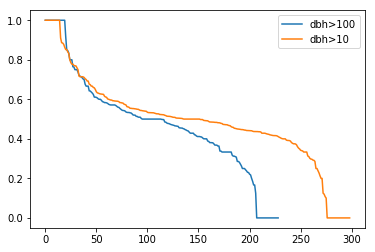

In [60]:
plt.plot(np.arange(s0),f10['frac'].sort_values(ascending=False),label='dbh>100mm')
plt.plot(np.arange(s01),f1['frac'].sort_values(ascending=False),label='dbh>10mm')
plt.legend()

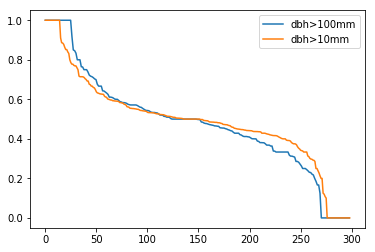

In [62]:
# Correct for different species numbers
plt.plot(np.arange(s0)/s0*s01,f10['frac'].sort_values(ascending=False),label='dbh>100mm')
plt.plot(np.arange(s01),f1['frac'].sort_values(ascending=False),label='dbh>10mm')
plt.legend()

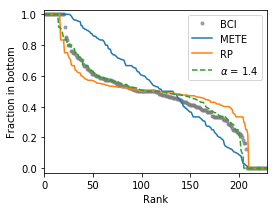

In [4]:
# For paper showing why rank ordering is bad:

# For sampling from an array instead. Don't need to pass max because it can be found.
def rs_arr(p,xbounds,state):
    while True:
        x = state.randint(xbounds[0],xbounds[1]+1)
        y = state.rand(1)*p.max()
        if y<=p[x]:
            return x
# Setup colors
colors = plt.get_cmap("tab10")
        
# Plot the bisection data
fig,ax = plt.subplots(figsize=(4,3))
x = np.arange(s0)+1
x2 = np.arange(0,s0+2) # To match up at the end
# Data
ax.plot(x,f10['frac'].sort_values(ascending=False),'.',c=colors(7),alpha=0.7,label='BCI')

# Fits
# For each n0, draw a corresponding point from the alpha distribution, then rank order
# I think fraction should be in the same order as c_trim, so let's do it that way.
dda_multi = np.zeros(s0) # For density dependent
bi_multi = np.zeros(s0) # For binomial
mete_multi = np.zeros(s0)
# Set random seed for variates:
rng = np.random.RandomState(1)
# Set alpha
al = 1.4
# Loop for all n0
for i,n in enumerate(f10['n0'].values):
    prob = dd.dd_prob(n,al)
    dda_multi[i] = rs_arr(prob,(0,n),rng)/n
    bi_multi[i] = st.binom.rvs(n,p=0.5,random_state=rng)/n
    mete_multi[i] = np.random.randint(n+2)/(n+1) # Range is not inclusive
bi_args = np.argsort(bi_multi)[::-1]
dda_args = np.argsort(dda_multi)[::-1]
mete_args = np.argsort(mete_multi)[::-1]
bi_multi_ro = np.sort(bi_multi)[::-1]
dda_multi_ro = np.sort(dda_multi)[::-1]
mete_multi_ro = np.sort(mete_multi)[::-1]
# METE
ax.plot(x,mete_multi_ro,label='METE')
# Binomial
ax.plot(x,bi_multi_ro,label='RP')
# Density dependent
ax.plot(x,dda_multi_ro,'--',label=r'$\alpha$ = {}'.format(al))


# Prettify
ax.set_xlim(0,x[-1])
ax.set_ylim(-0.03,1.03)
ax.set_xlabel('Rank')
ax.set_ylabel('Fraction in bottom')
ax.legend()
# 5 stands for bci5 data
plt.savefig('BCIcomp_5.pdf',format='pdf',bbox_inches='tight')
plt.savefig('Manuscript/BCIro_5.eps',format='eps',bbox_inches='tight')
plt.savefig('Manuscript/BCIro_5.pdf',format='pdf',bbox_inches='tight')
plt.show()

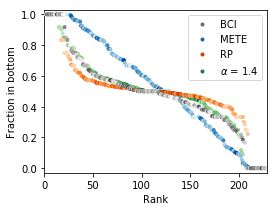

In [16]:
# NB: MUST RUN ABOVE CELL BEFORE THIS ONE

# To help explain why this a problematic way of doing it (with the rank ordering), let's use colors.
# Darker points have large n0
fig,ax = plt.subplots(figsize=(4,3))
args = np.argsort(f10['frac'].sort_values(ascending=False))[::-1]

# BCI
ax.scatter(x,f10['frac'].sort_values(ascending=False),c=np.log10(f10['n0'].sort_values(ascending=False))[args],
           cmap=plt.get_cmap('Greys'),marker='.',alpha=0.7,zorder=10,label='BCI')
# METE
ax.scatter(x,mete_multi_ro,c=np.log10(f10['n0'].sort_values(ascending=False))[mete_args],
           cmap=plt.get_cmap('Blues'),marker='.',label='METE')
# Binomial
ax.scatter(x,bi_multi_ro,c=np.log10(f10['n0'].sort_values(ascending=False))[bi_args],
           cmap=plt.get_cmap('Oranges'),marker='.',label='RP')
# Density dependent
ax.scatter(x,dda_multi_ro,c=np.log10(f10['n0'].sort_values(ascending=False))[dda_args],
           cmap=plt.get_cmap('Greens'),marker='.',zorder=0,label=r'$\alpha$ = {}'.format(al))


ax.set_xlabel('Rank')
ax.set_ylabel('Fraction in bottom')
ax.legend()
legend = ax.get_legend()
legend.legendHandles[0].set_color(plt.cm.Greys(.8))
legend.legendHandles[1].set_color(plt.cm.Blues(.8))
legend.legendHandles[2].set_color(plt.cm.Oranges(.8))
legend.legendHandles[3].set_color(plt.cm.Greens(.8))

ax.set_xlim(0,x[-1])
ax.set_ylim(-0.03,1.03)

plt.savefig('BCIcomp_5_heat.pdf',format='pdf',bbox_inches='tight')
plt.savefig('Manuscript/BCIro_5_heat.eps',format='eps',bbox_inches='tight')
plt.savefig('Manuscript/BCIro_5_heat.pdf',format='pdf',bbox_inches='tight')
plt.show()

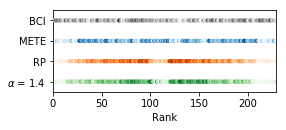

In [25]:
# Try plotting these lines with only the trends rather than overlapping so we can see the difference:
# NB: MUST RUN ABOVE CELL BEFORE THIS ONE

# To help explain why this a problematic way of doing it (with the rank ordering), let's use colors.
# Darker points have large n0
fig,ax = plt.subplots(figsize=(4,1.5))
args = np.argsort(f10['frac'].sort_values(ascending=False))[::-1]

# BCI
ax.scatter(x,[4]*s0,c=np.log10(f10['n0'].sort_values(ascending=False))[args],
           cmap=plt.get_cmap('Greys'),marker='.',alpha=0.7,zorder=10,label='BCI')
# METE
ax.scatter(x,[3]*s0,c=np.log10(f10['n0'].sort_values(ascending=False))[mete_args],
           cmap=plt.get_cmap('Blues'),marker='.',label='METE')
# Binomial
ax.scatter(x,[2]*s0,c=np.log10(f10['n0'].sort_values(ascending=False))[bi_args],
           cmap=plt.get_cmap('Oranges'),marker='.',label='RP')
# Density dependent
ax.scatter(x,[1]*s0,c=np.log10(f10['n0'].sort_values(ascending=False))[dda_args],
           cmap=plt.get_cmap('Greens'),marker='.',zorder=0,label=r'$\alpha$ = {}'.format(al))


ax.set_xlabel('Rank')
ax.set_yticks([1,2,3,4])
ax.set_yticklabels([r'$\alpha$ = {}'.format(al),'RP','METE','BCI'])
#ax.set_ylabel('Fraction in bottom')
#ax.legend()
#legend = ax.get_legend()
#legend.legendHandles[0].set_color(plt.cm.Greys(.8))
#legend.legendHandles[1].set_color(plt.cm.Blues(.8))
#legend.legendHandles[2].set_color(plt.cm.Oranges(.8))
#legend.legendHandles[3].set_color(plt.cm.Greens(.8))

ax.set_xlim(0,x[-1])
ax.set_ylim(0.5,4.5)

plt.savefig('BCIcomp_5_heat_lines.pdf',format='pdf',bbox_inches='tight')
plt.savefig('Manuscript/BCIro_5_heat_lines.eps',format='eps',bbox_inches='tight')
plt.savefig('Manuscript/BCIro_5_heat_lines.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [98]:
# Calculate log likelihoods for manuscript table
mete_ll = 0.
bi_ll = 0.
dd14_ll = 0.
dd112_ll = 0.
for i,n in enumerate(f10['n0'].values):
    ni = int(np.around(f10['frac'][i]*n))
    mete_ll += -np.log(1/(n+1))
    bi_ll += -np.log(st.binom.pmf(ni,n,p=0.5))
    dd14_ll += -np.log(dd.dd_prob(n,1.4)[ni])
    dd112_ll += -np.log(dd.dd_prob(n,1.12)[ni])
print('METE: {}'.format(mete_ll))
print('Binomial: {}'.format(bi_ll))
print('a=1.4: {}'.format(dd14_ll))
print('a=1.12: {}'.format(dd112_ll))

METE: 728.7097286584712
Binomial: 963.0670787863634
a=1.4: 718.4085815556849
a=1.12: 659.8470719009746


# Get $\alpha$

In [4]:
# Get bestfit alpha to put in contours:
al10 = minimize_scalar(dd.loglikelihood,bounds=(0.8,1.5),method='bounded',
                args=(np.rint(f10['frac']*f10['n0']).astype(int),f10['n0']))

In [5]:
al10

     fun: 659.837902607894
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 1.1224099629374666

In [19]:
# Compare to other models and make sure it's working:
print(dd.loglikelihood(al10.x,np.rint(f10['frac']*f10['n0']).astype(int),f10['n0']))
# METE
print(-np.sum(np.log(1/(f10['n0']+1))))
# RP
print(-np.sum(st.binom.logpmf(np.rint(f10['frac']*f10['n0']).astype(int),f10['n0'], 0.5)))
print("p-value: {}".format(
  1-st.chi2.cdf(2*(-np.sum(np.log(1/(f10['n0']+1)))-dd.loglikelihood(
      al10.x,np.rint(f10['frac']*f10['n0']).astype(int),f10['n0'])),1)))

659.837902607894
728.7097286584718
963.0670787863642
p-value: 0.0


In [6]:
al1 = minimize_scalar(dd.loglikelihood,bounds=(0.9,1.2),method='bounded',
                args=(np.rint(f1['frac']*f1['n0']).astype(int),f1['n0']))

In [7]:
al1

     fun: 1234.9807018892106
 message: 'Solution found.'
    nfev: 13
  status: 0
 success: True
       x: 1.0210606414921735

In [17]:
# Compare to other models:
print(dd.loglikelihood(al1.x,np.rint(f1['frac']*f1['n0']).astype(int),f1['n0']))
# METE
print(-np.sum(np.log(1/(f1['n0']+1))))
# RP
print(-np.sum(st.binom.logpmf(np.rint(f1['frac']*f1['n0']).astype(int),f1['n0'], 0.5)))

1234.9807018892106
1323.6537418391704
4377.78872951978


# Contour data

In [33]:
# Get 95% contour information
pc = 0.05 # 95 percent contour

# Using dd_functions for METE:
abund10 = bciA['sp'].value_counts()
nmax = abund10[0]
logrange,dda_int = dd.contours(al10.x,pc,nmax)
# Set up arrays
#dda_int = []
bi_int = []
mete_int = []
#c_trim = bciA['sp'].value_counts()
#logrange = np.unique(np.logspace(np.log10(c_trim[-1]),np.log10(c_trim[0]),dtype=int)) # No reason to do it twice
for n in logrange: # Use max from c_trim, but sample logarithmically
    # Density dependence
    #dda_cdf_t = np.cumsum(dd_prob(n,al))
    #dda_int.append((np.searchsorted(dda_cdf_t,pc/2)/n,np.searchsorted(dda_cdf_t,1-pc/2)/n))
    # Test
    #print(np.sum(dda_vec(n,al)[dda_int[0]:dda_int[1]]))
    #print(dda_cdf_t[dda_int[1]]-dda_cdf_t[dda_int[0]])
    # Binomial
    bi_int_t = st.binom.interval(1-pc,n,0.5)
    bi_int.append((bi_int_t[0]/n,bi_int_t[1]/n))
    # Test
    #print(np.sum(st.binom.pmf(np.arange(bi_int[0],bi_int[1]),n,0.5)))
    #print(st.binom.cdf(bi_int[1],n,0.5)-st.binom.cdf(bi_int[0],n,0.5))
    # METE
    mete_int.append((np.floor(pc/2*(n+1))/(n+1),np.ceil((1-pc/2)*(n+1))/(n+1)))
    # Test
    #print((mete_int[1]-mete_int[0])/(n+1))


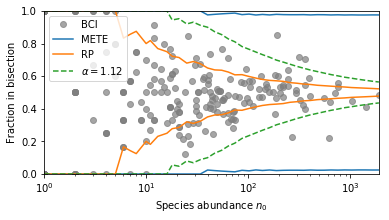

In [94]:
# Now plot these contour intervals
fig,ax = plt.subplots(figsize=(6,3))
colors = plt.get_cmap("tab10")
# Plot with abundance on x instead of rank ordering
bcip = ax.semilogx(abund10.sort_index(),f10['frac'],'o',c=colors(7),alpha=0.7,label='BCI')
metep = ax.semilogx(logrange,mete_int,c=colors(0),label='METE')
bip = ax.semilogx(logrange,bi_int,c=colors(1),label='RP')
alp = ax.semilogx(logrange,dda_int,'--',c=colors(2),label=r'$\alpha={:.2f}$'.format(al10.x))
ax.legend((bcip[0],metep[0],bip[0],alp[0]),('BCI','METE','RP',r'$\alpha={:.2f}$'.format(al10.x)))
ax.set_ylim(0,1)
#ax.set_xlim(c_trim[-1],c_trim[0])
ax.set_xlim(1,nmax)
ax.set_ylabel('Fraction in bisection')
ax.set_xlabel(r'Species abundance $n_0$')
plt.savefig('Manuscript/Contours.eps',format='eps',bbox_inches='tight')
plt.savefig('Manuscript/Contours.pdf',format='pdf',bbox_inches='tight')
plt.savefig('Contours_2005_10cm.pdf',format='pdf',bbox_inches='tight')

In [19]:
# So it looks like there are fewer points outside of the contours!

In [38]:
# Let's double check these for 1cm

# Using dd_functions for METE:
abund1 = bciA1['sp'].value_counts()
nmax1 = abund1[0]
logrange1,dda1_int = dd.contours(al1.x,pc,nmax1)
# Set up arrays
#dda_int = []
bi1_int = []
mete1_int = []
for n in logrange1:
    bi1_int_t = st.binom.interval(1-pc,n,0.5)
    bi1_int.append((bi1_int_t[0]/n,bi1_int_t[1]/n))
    mete1_int.append((np.floor(pc/2*(n+1))/(n+1),np.ceil((1-pc/2)*(n+1))/(n+1)))

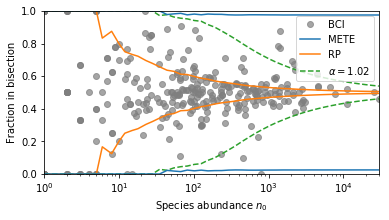

In [95]:
# Now plot these contour intervals
fig,ax = plt.subplots(figsize=(6,3))
colors = plt.get_cmap("tab10")
# Plot with abundance on x instead of rank ordering
bcip = ax.semilogx(abund1.sort_index(),f1['frac'],'o',c=colors(7),alpha=0.7,label='BCI')
bip = ax.semilogx(logrange1,bi1_int,c=colors(1),label='RP')
alp = ax.semilogx(logrange1,dda1_int,'--',c=colors(2),label=r'$\alpha={:.2f}$'.format(al1.x))
metep = ax.semilogx(logrange1,mete1_int,c=colors(0),label='METE')
ax.legend((bcip[0],metep[0],bip[0],alp[0]),('BCI','METE','RP',r'$\alpha={:.2f}$'.format(al1.x)))
ax.set_ylim(0,1)
ax.set_xlim(1,nmax1)
ax.set_ylabel('Fraction in bisection')
ax.set_xlabel(r'Species abundance $n_0$')
plt.savefig('Contours_2005_1cm.pdf',format='pdf',bbox_inches='tight')